In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier # horrible because inbalanced classes
from sklearn.linear_model import LogisticRegression # sucks
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import NuSVC
from sklearn.svm import SVC
import shlex
import subprocess
import sys
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, TorsionFingerprints
from rdkit.Chem import Descriptors
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem.AtomPairs import Torsions
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import Draw
from multiprocessing import Pool
import math
import timeit
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from e3fp.fingerprint.generate import fp, fprints_dict_from_mol
# from e3fp.conformers.generate import generate_conformers
from e3fp.pipeline import fprints_from_smiles
import cirpy
import random

In [2]:
a = "CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O"
b = "CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[13C@H]1O"

AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(a),2,useChirality=True,nBits=2048) == AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(b),2,useChirality=True,nBits=2048)

False

In [3]:
df = pd.read_excel('SixC-Ring SMILES final chemical library v3.xlsx')
df.drop(columns=df.columns[3:],inplace=True)
df.columns = ['smiles', 'names', 'label']
df['label'] = [i[0] == 'a' for i in df['label']]


bits = int(2048)

smiles = df['smiles']
names = df['names']
molecs = [Chem.MolFromSmiles(i, sanitize=False) for i in smiles]
[Chem.SanitizeMol(s,sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL^Chem.SanitizeFlags.SANITIZE_KEKULIZE) for s in molecs]
[i.SetProp("_Name",j) for i,j in zip(molecs,names)]
molecs = [i for i in molecs if not i == None]
fingerprint = np.array([AllChem.GetMorganFingerprintAsBitVect(i,2,useChirality=True,nBits=bits) for i in molecs])


label = df['label']
tot = len(label)
pos = sum(label)
neg = tot - sum(label)




# print(df)
print(f"FULL Dataset: {df.shape}")
print("Fingerprint:",fingerprint.shape,"Sparcity:",np.mean(fingerprint))


FULL Dataset: (173, 3)
Fingerprint: (173, 2048) Sparcity: 0.01209131141618497


# Model Choice

In [4]:

trialsp = 1
trialsn = 1

print('SGD')

individual = lambda: make_pipeline(
    VarianceThreshold(),
    SGDClassifier(loss='modified_huber', penalty='elasticnet', class_weight={0: 0.005, 1: 1}, validation_fraction=sys.float_info.min,n_jobs=-1)
)
getmodel = lambda: VotingClassifier( [(str(i),individual()) for i in range(10)], voting= 'soft', n_jobs=-1)

for _ in range(3):

    def test_model(i):
        short_finger = list(fingerprint[:i%pos]) + list(fingerprint[(i%pos)+1:])
        model = getmodel()
        model.fit(short_finger,label[1:])
        print('.',end='')
        return model.score([fingerprint[i%pos]],[1])/trialsp/pos
    correct1 = sum(map(test_model,range(trialsp*pos)))
    print(f"+{round(correct1,2)}",end='')
    # print(f"model acccuracy for posatives: {correct1}")
    def test_model(i):
        short_finger = list(fingerprint[:pos+(i%neg)]) + list(fingerprint[pos+1+(i%neg):])
        model = getmodel()
        model.fit(short_finger,label[:-1])
        print('.',end='')
        return model.score([fingerprint[pos+(i%neg)]],[0])/trialsn/neg
    correct0 = sum(map(test_model,range(trialsn*neg)))
    print(f"-{round(correct0,2)}",end='')
#     print(f"model acccuracy for negatives: {correct0}")
    ppv = correct1*pos/(correct1*pos+(1-correct0)*neg)
#     print(f"P(1 | predict 1) = P(predict 1 | 1) P(1) / P(predict 1) = {ppv}")
    print(f"\n#  {len(fingerprint[0])}: ({round(correct1,2)}, {round(correct0,2)}, {round(ppv,2)})")

# SGDClassifier(loss='modified_huber', class_weight={0: 0.005, 1: 1}, validation_fraction=sys.float_info.min,n_jobs=-1)
#  2048: (0.7, 0.82, 0.19)
#  2048: (0.6, 0.79, 0.15)
#  2048: (0.7, 0.82, 0.19)

# SGDClassifier(loss='modified_huber', penalty='elasticnet', class_weight={0: 0.005, 1: 1}, validation_fraction=sys.float_info.min,n_jobs=-1)
#  2048: (0.9, 0.83, 0.24)
#  2048: (0.8, 0.82, 0.21)
#  2048: (0.8, 0.83, 0.22)
#  2048: (0.8, 0.83, 0.23)
#  2048: (0.8, 0.82, 0.21)
#  2048: (0.8, 0.82, 0.22)


print('done!')

SGD
..........+0.8...................................................................................................................................................................-0.83
#  2048: (0.8, 0.83, 0.23)
..........+0.8...................................................................................................................................................................-0.82
#  2048: (0.8, 0.82, 0.21)
..........+0.8...................................................................................................................................................................-0.82
#  2048: (0.8, 0.82, 0.22)
done!


In [15]:
individual = lambda: make_pipeline(
    VarianceThreshold(),
    SGDClassifier(loss='modified_huber', penalty='elasticnet', class_weight={0: 0.005, 1: 1}, validation_fraction=sys.float_info.min,n_jobs=-1)
)
getmodel = lambda: VotingClassifier( [(str(i),individual()) for i in range(10)], voting= 'soft', n_jobs=-1)

measurements = 3

means = []
stds = []
truths = []
for test in range(len(label)):
    testfp = fingerprint[test,:]
    truth = label[test]
    trainfp = np.array([i for e,i in enumerate(fingerprint) if e != test])
    trainlab = np.array([i for e,i in enumerate(label) if e != test])
    print(test,'/',len(label),'Leaving out: ',names[test],'=',label[test])
    # print('Training on',fingerprint.shape,'data')
    chemscore = []
    for _ in range(measurements):
        model = getmodel()
        model.fit(trainfp,trainlab)


        prediction = model.predict_proba([testfp])[0][1]
        chemscore.append(prediction)
    means.append(np.mean(chemscore))
    stds.append(np.std(chemscore))
    truths.append(truth)
    print('Mean Error:',round(label[test] - np.mean(chemscore),4),'Std:',round(np.std(chemscore),3))
print('Done!')

0 / 173 Leaving out:  Meglumine = True
Training on (173, 2048) data
Mean Error: 0.703 Std: 0.213
1 / 173 Leaving out:  D-(+)-Mannose = True
Training on (173, 2048) data
Mean Error: 0.2078 Std: 0.072
2 / 173 Leaving out:  sn-Glycerol 3-phosphate bis(cyclohexylammonium) salt = True
Training on (173, 2048) data
Mean Error: 0.7333 Std: 0.205
3 / 173 Leaving out:  1-Deoxy-1-morpholino-D-fructose = True
Training on (173, 2048) data
Mean Error: 0.1 Std: 0.0
4 / 173 Leaving out:  D-Fructose 6-phosphate dipotassium salt = True
Training on (173, 2048) data
Mean Error: 0.1 Std: 0.082
5 / 173 Leaving out:  D-(-)-Fructose = True
Training on (173, 2048) data
Mean Error: 0.0 Std: 0.0
6 / 173 Leaving out:  D-(+)-Turanose = True
Training on (173, 2048) data
Mean Error: 0.3667 Std: 0.047
7 / 173 Leaving out:  D-(+)-Glucose = True
Training on (173, 2048) data
Mean Error: 0.128 Std: 0.059
8 / 173 Leaving out:  D-Glucamine = True
Training on (173, 2048) data
Mean Error: 0.1781 Std: 0.059
9 / 173 Leaving ou

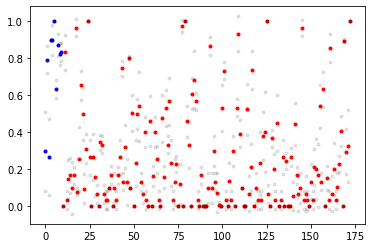

In [16]:
plt.plot(*zip(*[(x,y) for y,j,x in zip(means,truths,range(len(means))) if j]),'.',color='blue')
plt.plot(*zip(*[(x,m+y) for m,y,j,x in zip(means,stds,truths,range(len(means))) if j]),'.',alpha=0.1,color='black')
plt.plot(*zip(*[(x,m-y) for m,y,j,x in zip(means,stds,truths,range(len(means))) if j]),'.',alpha=0.1,color='black')
plt.plot(*zip(*[(x,y) for y,j,x in zip(means,truths,range(len(means))) if not j]),'.',color='red')
plt.plot(*zip(*[(x,m+y) for m,y,j,x in zip(means,stds,truths,range(len(means))) if not j]),'.',alpha=0.1,color='black')
plt.plot(*zip(*[(x,m-y) for m,y,j,x in zip(means,stds,truths,range(len(means))) if not j]),'.',alpha=0.1,color='black')
plt.show()

(173, 2048)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Text(0.5, 1.0, 'UMAP')

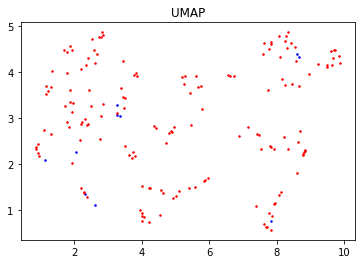

In [58]:
import umap.umap_ as umap
# import numba

# @numba.njit()
# def tanimoto_d(u, v):
#     return 1 - sum([i*j for i,j in zip(u,v)]) / sum([i+j - i*j for i,j in zip(u,v)])
print(fingerprint.shape)
embedding_umap = umap.UMAP(metric='cosine').fit_transform(PCA(n_components=30).fit_transform(fingerprint))
fig = plt.figure()
ax = plt.axes()
ax.plot(*embedding_umap[:pos].T, "b.", markersize=3)
ax.plot(*embedding_umap[pos:].T, "r.", markersize=3)
ax.set_title('UMAP')


# Chiral morgon fingerprint with 2048 bits

on an comittee of 10 SGDClassifier(loss='modified_huber', penalty='elasticnet', class_weight={0: 0.005, 1: 1}, validation_fraction=sys.float_info.min,n_jobs=-1)s


In [29]:
individual = lambda: make_pipeline(
    VarianceThreshold(),
    SGDClassifier(loss='modified_huber', penalty='elasticnet', class_weight={0: 0.005, 1: 1}, validation_fraction=sys.float_info.min,n_jobs=-1)
)
getmodel = lambda: VotingClassifier( [(str(i),individual()) for i in range(10)], voting= 'soft', n_jobs=-1)
model = getmodel()
print("model built!")
model.fit(fingerprint,label)
print("model fit!")
def model_on_list(x):
    result = []
    for s in x:
        s = Chem.MolFromSmiles(s, sanitize=False) # https://github.com/rdkit/rdkit/issues/46 (because I'm using this on broken substructures)
        Chem.SanitizeMol(s,sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL^Chem.SanitizeFlags.SANITIZE_KEKULIZE)
        fingerprint = np.array([AllChem.GetMorganFingerprintAsBitVect(s,2,useChirality=True,nBits=bits)])
        result.append(model.predict_proba(fingerprint)[0][1])
    return result

model built!
model fit!


In [33]:
def submolecules(molecule):
    submolecules = set([molecule])
    molecule = Chem.MolFromSmiles(molecule)
    
    atoms = [i for i in molecule.GetAtoms() if i.GetAtomicNum() != 1]
    atoms.sort(key=lambda x: x.GetIdx(),reverse=True)
    numatoms = len(atoms)
    print(f'Generating {2**numatoms - 2} submolecules using {numatoms} atoms')
    for subinds in range(1,(2**numatoms)-1):
        deletions = [((subinds//2**i)%(2**(i+1))) == 0 for i in range(numatoms)]
        # print(deletions)
        new_mol = Chem.EditableMol(molecule)
        for ind,delete in enumerate(deletions):
            if delete:
                for bond in atoms[ind].GetNeighbors():
                    new_mol.RemoveBond(atoms[ind].GetIdx(),bond.GetIdx())
        for ind,delete in enumerate(deletions):
            if delete:
                new_mol.RemoveAtom(atoms[ind].GetIdx())
        new_mol = new_mol.GetMol()




        # Chem.SanitizeMol(new_mol)

        
        new_mol = Chem.MolToSmiles(new_mol)
        if not new_mol in submolecules:
            print('.',end='')
            submolecules.add(new_mol)
    print(f'\nReturning {len(submolecules)} unique submolecules')
    return submolecules




main_mols = []
legend = []
for molecule_tested in range(len(smiles)):
    pred = model_on_list([smiles[molecule_tested]])[0]
    print(f"{molecule_tested}/{len(smiles)}\t{names[molecule_tested]}:\t{smiles[molecule_tested]}\t--\tscore = {round(pred,2)}")


    substructs = 2**len([i for i in Chem.MolFromSmiles(smiles[molecule_tested]).GetAtoms() if i.GetAtomicNum() != 1]) - 2
    if substructs > 10**5:
        print(f"{substructs} substructures is to many :'(")
        continue

    pcut = 0.5

    # if pred < pcut:
    #     print("WARNING: FULL MOLECULE PREDICTED NOT TO BIND\n\tSCORE = ",round(pred,2))

    print("running exhaustive search...")
    subs = submolecules(smiles[molecule_tested])
    # print(f"found {len(subs)} submolecules...:{subs}")
    passing_subs = [(i,j,) for i,j in zip(model_on_list(subs),subs) if i > pcut]
    print(f"Found {len(passing_subs)} posative submolecules!")

    template = Chem.MolFromSmiles(smiles[molecule_tested])
    AllChem.Compute2DCoords(template)
    # for i,n in enumerate(passing_subs):
    #     print(f"Submolecule {i}:\tScore = {round(n[0],2)}\t{n[1]}")
    mMols = [Chem.MolFromSmiles(smiles[molecule_tested])] + [Chem.MolFromSmiles(m[1], sanitize=False) for m in passing_subs]

    # if pred < pcut:
    #     print("WARNING: FULL MOLECULE PREDICTED NOT TO BIND\n\tSCORE = ",round(pred,2))
        
    print('Done!')

    fragments = [mMols[0].GetSubstructMatches(m,maxMatches=100000000,useChirality=True) for m in mMols[1:]]
    for at in mMols[0].GetAtoms():
        overlaps = [max([at.GetIdx() in f for f in i]+[0]) for i in fragments]
        at.SetProp('atomNote',f"{round(sum(overlaps)/(len(fragments)+sys.float_info.min),2)}")
        
    main_mols.append(mMols[0])
    legend.append(f"{smiles[molecule_tested]}\n{names[molecule_tested]}\n{len(fragments)} successfull submolecules")
    
Draw.MolsToGridImage(main_mols,legends=legend, maxMols=100000000, molsPerRow=5, subImgSize=(250,250), useSVG=True)

0/173	Meglumine:	O[C@@H](CNC)[C@H]([C@@H]([C@@H](CO)O)O)O	--	score = 1.0
running exhaustive search...
Generating 8190 submolecules using 13 atoms
.........................................................................................................................................................................
Returning 170 unique submolecules
Found 84 posative submolecules!
Done!
1/173	D-(+)-Mannose:	O[C@H]1[C@H](O)[C@H](O)C(O)O[C@@H]1CO	--	score = 1.0
running exhaustive search...
Generating 4094 submolecules using 12 atoms
....................................................................................................................................
Returning 133 unique submolecules
Found 14 posative submolecules!
Done!
2/173	sn-Glycerol 3-phosphate bis(cyclohexylammonium) salt:	OC[C@H](COP(O)(O)=O)O	--	score = 1.0
running exhaustive search...
Generating 1022 submolecules using 10 atoms
................................................................
Returning 65 unique submo

# Scoring Catalogs

In [4]:
individual = lambda: make_pipeline(
    VarianceThreshold(),
    SGDClassifier(loss='modified_huber', penalty='elasticnet', class_weight={0: 0.005, 1: 1}, validation_fraction=sys.float_info.min,n_jobs=-1)
)
getmodel = lambda: VotingClassifier( [(str(i),individual()) for i in range(10)], voting= 'soft', n_jobs=-1)
model = getmodel()
print("model built!")
model.fit(fingerprint,label)
print("model fit!")

# df = pd.read_excel('Test Set - Similar to Glucose.xlsx', dtype=str)
# supplier = 'SantaCruztBioTech'
# supplier = 'BioSynth'
# df = pd.read_csv(supplier+'StockListCarbohydratesFiltered_v3.csv', dtype=str)
supplier = 'AkosSamples'
df = pd.read_excel(supplier+'.xls', dtype=str)
df.columns = ['SMILES','Name'] + ['junk' for i in range(len(df.columns)-2)]
blacklist = ['.','2H','3H','11C','12C','13C','14C','15O','15N']
# blacklist = []
df = df[[all([b not in i for b in blacklist]) for i in df['SMILES']]]
df = df[['nan' != str(i) for i in df['Name']]]

# print(df)
def run_on_one(s):
    s = Chem.MolFromSmiles(s)
    if s == None:
        return 0
    else:
        return model.predict_proba([AllChem.GetMorganFingerprintAsBitVect(s,2,useChirality=True,nBits=bits)])[0][1]
def model_on_list(x):
    pool = Pool(16)
    result = list(pool.map(run_on_one,x))
    pool.close()
    pool.join()
    return result

train_reslt = model_on_list(smiles)
predictions = np.array(train_reslt) - np.array(label)
print('Largest error on training data:',max(abs(predictions)))


inp = list(df['SMILES'])
predictions = list(zip(model_on_list(inp),df['Name'],df['SMILES']))
predictions = [(float(i),str(j),str(k)) for i,j,k in predictions]
predictions.sort(reverse=True)

plt.plot([i[0] for i in predictions])
plt.show()

Training model!
Model trained!
Largest error on training data: 0.003227028303424362


KeyboardInterrupt: 

In [ ]:
posatives = [i for i in predictions if i[0] > 0.5]
print('Hits:',len(posatives))
x = pd.DataFrame(posatives)
x.columns=['Score','Name','SMILES']
# x.to_excel('GlucoseLikeHits.xlsx',index=False)
x.to_excel(supplier+'Hits.xlsx',index=False)

mMols = [Chem.MolFromSmiles(m[2]) for m in posatives]
x = Draw.MolsToGridImage(mMols,legends=[f'Molecule {x}\tScore = {round(i[0],2)}\n{i[1]}' for x,i in enumerate(posatives)], molsPerRow=9, maxMols = 100, subImgSize=(300,300), returnPNG=False)
# x.save('GlucoseLikeHits.png')
x.save(supplier+'Hits.png')

Hits: 0
Empty DataFrame
Columns: []
Index: []


ValueError: Length mismatch: Expected axis has 0 elements, new values have 3 elements

In [ ]:
%run MontyCarlo.ipynb



creativity = 0
def model_on_list(x):
    result = []
    for s in x:
        fingerprint = np.array([AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s),2,useChirality=True,nBits=bits)])
        result.append(model.predict_proba(fingerprint)[0][1]*(1-creativity)+0.5*creativity)
    return result

rollouts = 100

print("running monty carlo searches...")

main_mols = []
legends = []
for i, (score, name, smile) in enumerate(posatives):

    pred = (model_on_list([smile])[0] -0.5*creativity)/(1-creativity)
    print(f"prediction: {round(pred,2)}")

    min_molecule = mcts(
        smile,
        model_on_list,
        rollouts, # number of rollouts
        0.5, # probability cutoff
    )

    mMols = [Chem.MolFromSmiles(smile)] + [Chem.MolFromSmiles(m[1]) for m in set(min_molecule)]


    # for this, itself counts as a substructure
    fragments = [mMols[0].GetSubstructMatch(m) for m in mMols]
    for at in mMols[0].GetAtoms():
        overlaps = [at.GetIdx() in f for f in fragments]
        at.SetProp('atomNote',f"{round(sum(overlaps)/len(overlaps),2)}")

    main_mols.append(mMols[0])
    legends.append(name+f"\n{len(fragments)} minimal smiles found")
    print(f"{i} / {len(posatives)}")
x = Draw.MolsToGridImage(main_mols,legends=legends, molsPerRow=9, maxMols = 100, subImgSize=(300,300), returnPNG=False)
# x.save('GlucoseLikeHitsSubhits.png')
x.save(supplier+'LikeHitsSubhits.png')


running monty carlo searches...
prediction: 1.0
0 / 2
prediction: 0.96
1 / 2
